# Сборный проект. Определение параметров, определяющих успешность игры

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Описание данных:
- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales* — продажи в Северной Америке (миллионы проданных копий)
- *EU_sales* — продажи в Европе (миллионы проданных копий)
- *JP_sales* — продажи в Японии (миллионы проданных копий)
- *Other_sales* — продажи в других странах (миллионы проданных копий)
- *Critic_Score* — оценка критиков (максимум 100)
- *User_Score* — оценка пользователей (максимум 10)
- *Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Изучение данных из файла

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/datasets/games.csv')

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В таблице 11 столбцов с разным количеством значений, в некоторых имеются пропуски. 

Из таблицы и описания файла видим, что в таблице названия столбцов начинаются с верхнего регистра, который нужно будет преобразовать в нижний. Также имеются пропущенные значения. В столбце с годом выпуска нужно будет изменить тип данных.

## Предобработка данных

В данном шаге необходимо привести названия столбцов к нижнему регистру, преобразовать данные в нужные типы, обработать пропуски при необходимости. А также посчитать суммарные продажи во всех регионах и сохранить их в отдельном столбце.

In [ ]:
data.columns = data.columns.str.lower()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
data.duplicated().sum()

0

In [ ]:
data['name'].duplicated().sum()

5155

Проверили таблицу на дубликаты, их нет, но видим, что по названиям игр дубликаты есть, то есть в таблице представлены одни и те же игры с разных платформ.

In [ ]:
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [ ]:
data.dropna(subset=['year_of_release'], inplace=True)

In [ ]:
data['year_of_release'] = data['year_of_release'].astype('int')

В столбцах с названием игры и жанра имеется незначительное количество пропусков. Произвести логическую замену в них не получится, поэтому оставим их. 

Удалили строки, где отсутствует год выпуска игры, так как их мало и будет удобней заменить тип данных на целочисленный для дальнейшего анализа. Также среди оценок критиков и пользователей около половины и трети значений соответственно - пропуски. При их замене на среднее или медианное значение, распределение сместится и показатели перестанут показывать реальные значения, поэтому замена здесь не является необходимой. Рассмотрим также столбец с возрастным рейтингом.  

In [ ]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Возрастной рейтинг подразделяется на 8 типов, самый популярный среди них E - Everyone, то есть игры для всех, затем идет рейтинг T - Teen, M - Mature 17+,  E10+ - Everyone 10+. Пропусков в этом столбце также значительное число, поэтому заменять их на моду или медиану будет нелогично, но чтобы пропуски не мешали при дальнейшем анализе, заменим их на рейтинг RP (Rating Pending) - ожидающие рейтинга.

In [ ]:
data['rating'] = data['rating'].fillna(value='RP')

Рассмотрим подробней столбец с пользовательским рейтингом.

In [ ]:
data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.3       2
1         2
9.6       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Помимо пропущенных значений в столбце с оценкой пользователей есть 2424 значения "tbd" - to be defined/determined, то есть показатели, по которым оценки еще не определены. Возможно это игры, на которые еще мало отзывов и оценок, поэтому, чтобы рейтинг был справедливым, они отмечены tbd. Заполним эти значения NaN, чтобы данные оставались релевантными, так как в дальнейшем нам нужно будет призводить расчеты по этому столбцу и необходимо, чтобы он имел численный тип данных.

In [ ]:
data = data.replace(to_replace ="tbd", value = 'NaN')
data['user_score'] = data['user_score'].astype('float')

Посчитаем суммарные продажи по каждой игре во всех регионах и запишим их в отдельный столбец.

In [ ]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [ ]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38


## Исследовательский анализ данных

Проверим, сколько игр выпускалось в разные годы.

In [ ]:
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

Видим, что в период с 2006-2011 выпускалось свыше тысячи игр каждый код. Самое большое число в 2008 и 2009 году, 1427 и 1426 соответственно.

Проверим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам.

In [ ]:
platform_sales = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
platform_sales.columns = ['platform_sales']
platform_sales = platform_sales.sort_values(by = 'platform_sales', ascending = False)

In [ ]:
platform_sales

,platform_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Из списка видим, что наибольшие продажи были на шести платформах, начиная с седьмой разница в продажах значительная. Построим распределение по годам для каждой из этих шести платформ.

In [ ]:
top = platform_sales.query('platform_sales > 700')

In [ ]:
top1=top.index.values

In [ ]:
top6 = data[data['platform'].isin(top1)].pivot_table(
                        index=['year_of_release', 'platform'], 
                        values='total_sales', 
                        aggfunc=sum).reset_index()

Text(0.5, 1.0, 'Распределение продаж по годам платформы PS2')

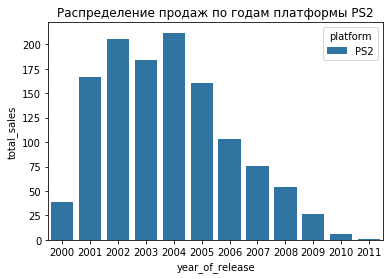

In [ ]:
PS2 = top6.query('platform == "PS2"')
sns.barplot(x = 'year_of_release', y = 'total_sales', hue = 'platform', data = PS2)
plt.title("Распределение продаж по годам платформы PS2")

Text(0.5, 1.0, 'Распределение продаж по годам платформы X360')

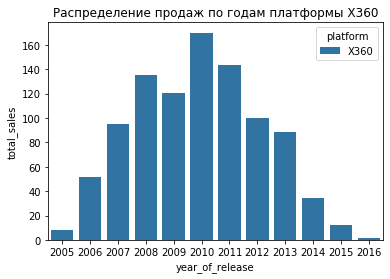

In [ ]:
X360 = top6.query('platform == "X360"')
sns.barplot(x = 'year_of_release', y = 'total_sales', hue = 'platform', data = X360)
plt.title("Распределение продаж по годам платформы X360")

Text(0.5, 1.0, 'Распределение продаж по годам платформы PS3')

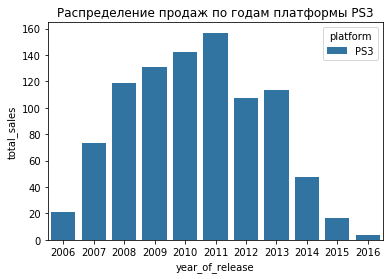

In [ ]:
PS3 = top6.query('platform == "PS3"')
sns.barplot(x = 'year_of_release', y = 'total_sales', hue = 'platform', data = PS3)
plt.title("Распределение продаж по годам платформы PS3")

Text(0.5, 1.0, 'Распределение продаж по годам платформы Wii')

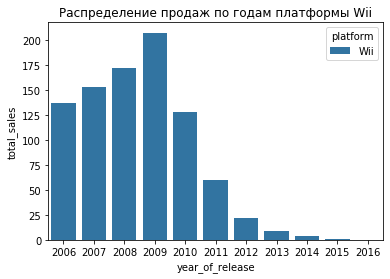

In [ ]:
Wii = top6.query('platform == "Wii"')
sns.barplot(x = 'year_of_release', y = 'total_sales', hue = 'platform', data = Wii)
plt.title("Распределение продаж по годам платформы Wii")

Text(0.5, 1.0, 'Распределение продаж по годам платформы DS')

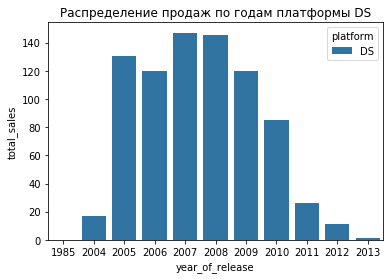

In [ ]:
DS = top6.query('platform == "DS"')
sns.barplot(x = 'year_of_release', y = 'total_sales', hue = 'platform', data = DS)
plt.title("Распределение продаж по годам платформы DS")

Text(0.5, 1.0, 'Распределение продаж по годам платформы PS')

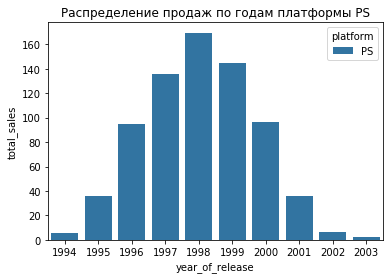

In [ ]:
PS = top6.query('platform == "PS"')
sns.barplot(x = 'year_of_release', y = 'total_sales', hue = 'platform', data = PS)
plt.title("Распределение продаж по годам платформы PS")

Рассмотрим время жизни каждой платформы с момента роста до момента спада продаж на платформе. Продажи игр платформы PS начались в 1994 году и росли до 1998, самой высокой точки продаж, затем они начали падать и пришли к 0 в 2003. Видим, что в 2000 году начались продажи игр платформы PS2 и росли до 2004 года, затем начался спад продажи упали в 2011. В 2006 году начались продажи игр PS3 и достигли максимума в 2011, после чего был спад и продажи упали в 2016 году. Это объясняется тем, что PlayStation выпускал новые модели, поэтому одна модель сменяла другую.

Платформа X360 начала продажи игр в 2005 и самое высокое число продаж было в 2010, после был спад и в 0 продажи пришли в 2016, платформа Wii - с 2006, рост до 2009 и падение в 2016, и платформа DS - рост с 2004 до 2008, продажи пришли в 0 в 2013.

Таким образом жизнь платформ составляет 9, 11, 10, 11, 10, 9, в среднем 9 лет.

Для планирования кампании на 2017 год и для дальнейшего анализа возьмем период 2014-2016 как актуальный, так как три года - это срок, за который продажи падают с пика до 0.

In [ ]:
actual_data = data.query('year_of_release >= 2014')

Рассмотрим, какие платформы лидируют по продажам, растут или падают в выбранный период.

In [ ]:
platform_leaders = actual_data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
platform_leaders

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


Сравнивая с предыдущим выводом, видим, что в выбранный период платформы Wii, DS, PS2, X360, PS упали в продажах. Теперь лидерами являются PS4, XOne, 3DS и PS3. 

Построим график «ящик с усами» по глобальным продажам игр в разбивке по лидирующим платформам и опишем полученный результат.

In [ ]:
leaders = actual_data.query('platform == ["PS4","XOne","3DS","PS3"]')

(0, 2)

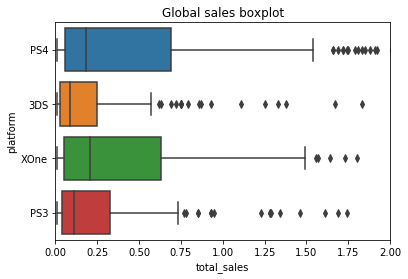

In [ ]:
sns.boxplot(y="platform", x='total_sales',orient = "h", data=leaders).set_title('Global sales boxplot')
plt.xlim(0, 2)

Из полученных боксплотов видим, что по всем платформам имеется длинный хвост выбросов. Самая большая медиана у платформы XOne, затем PS4, PS3 и 3DS.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами для каждой платформы. Сравним полученные данные.

In [ ]:
ps4_data = leaders.query('platform == "PS4"')
xone_data = leaders.query('platform == "XOne"')
ds3_data = leaders.query('platform == "3DS"')
ps3_data = leaders.query('platform == "PS3"')

Text(0.5, 1.0, 'Зависимость продаж от оценок пользователей (PS4)')

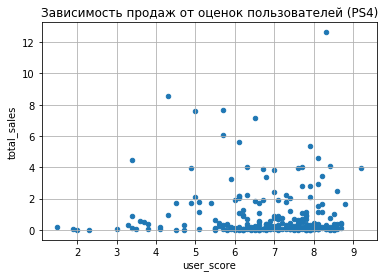

In [ ]:
ps4_data.plot(x='user_score', y='total_sales', kind='scatter', grid=True)
plt.title("Зависимость продаж от оценок пользователей (PS4)")

Text(0.5, 1.0, 'Зависимость продаж от оценок критиков (PS4)')

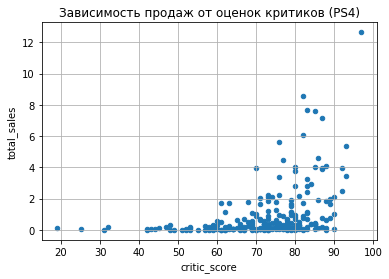

In [ ]:
ps4_data.plot(x='critic_score', y='total_sales', kind='scatter', grid=True)
plt.title("Зависимость продаж от оценок критиков (PS4)")

In [ ]:
ps4_data['user_score'].corr(ps4_data['total_sales'])

-0.040131589472697356

In [ ]:
ps4_data['critic_score'].corr(ps4_data['total_sales'])

0.40266141068104083

Исходя из диаграммы рассеяния по платформе PS4 и коэффициента корреляции Пирсона, видим, что есть зависимость общего количества продаж от оценок критиков. Коэффициент равен 0.40, зависимость не ярко-выраженная, но имеется. По диаграмме видим, что игры с самыми высокими продажами имеют высокие оценки критиков и значения справа тянутся вверх.

В то время как на диаграмме зависимости продаж от оценок пользователей, игры с высокими продажами имеют также и низкие оценки, и коэффициент корреляции близок к нулю, то есть зависимость очень слабая.

Рассмотрим также другие лидирующие платформы.

Text(0.5, 1.0, 'Зависимость продаж от оценок пользователей (XOne)')

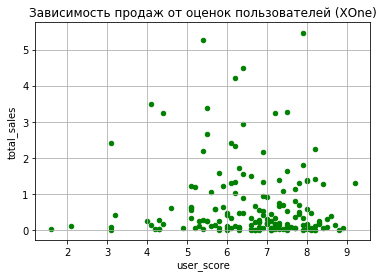

In [ ]:
xone_data.plot(x='user_score', y='total_sales', kind='scatter', c ="green", grid=True) 
plt.title("Зависимость продаж от оценок пользователей (XOne)")

Text(0.5, 1.0, 'Зависимость продаж от оценок критиков (XOne)')

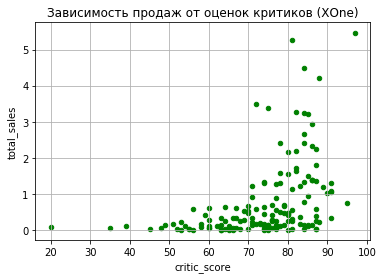

In [ ]:
xone_data.plot(x='critic_score', y='total_sales', kind='scatter', c ="green", grid=True) 
plt.title("Зависимость продаж от оценок критиков (XOne)")

In [ ]:
xone_data['user_score'].corr(xone_data['total_sales'])

-0.0703839280647581

In [ ]:
xone_data['critic_score'].corr(xone_data['total_sales'])

0.42867694370333226

Text(0.5, 1.0, 'Зависимость продаж от оценок пользователей (3DS)')

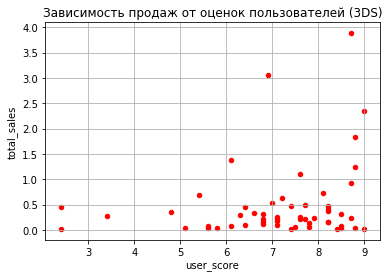

In [ ]:
ds3_data.plot(x='user_score', y='total_sales', kind='scatter', c ="red", grid=True) 
plt.title("Зависимость продаж от оценок пользователей (3DS)")

Text(0.5, 1.0, 'Зависимость продаж от оценок критиков (3DS)')

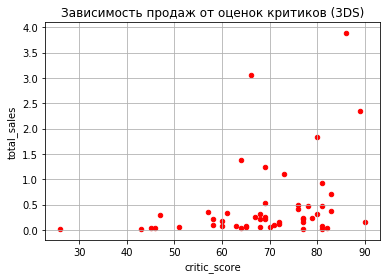

In [ ]:
ds3_data.plot(x='critic_score', y='total_sales', kind='scatter', c ="red", grid=True) 
plt.title("Зависимость продаж от оценок критиков (3DS)")

In [ ]:
ds3_data['user_score'].corr(ds3_data['total_sales'])

0.2151932718527028

In [ ]:
ds3_data['critic_score'].corr(ds3_data['total_sales'])

0.314117492869051

Text(0.5, 1.0, 'Зависимость продаж от оценок пользователей (PS3)')

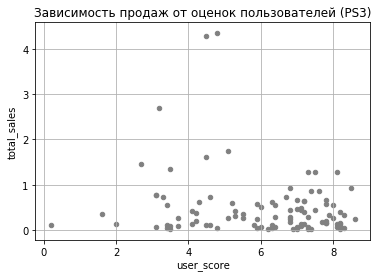

In [ ]:
ps3_data.plot(x='user_score', y='total_sales', kind='scatter', c = "grey",grid=True) 
plt.title("Зависимость продаж от оценок пользователей (PS3)")

Text(0.5, 1.0, 'Зависимость продаж от оценок критиков (PS3)')

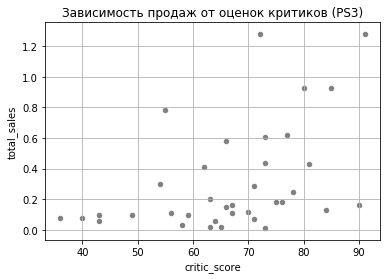

In [ ]:
ps3_data.plot(x='critic_score', y='total_sales', kind='scatter', c = "grey",grid=True) 
plt.title("Зависимость продаж от оценок критиков (PS3)")

In [ ]:
ps3_data['user_score'].corr(ps3_data['total_sales'])

-0.16676141347662118

In [ ]:
ps3_data['critic_score'].corr(ps3_data['total_sales'])

0.44657460493190704

Диаграммы по другим платформам также подтверждают, что продажи больше зависят от оценок критиков, чем пользователей, видим, что точки на графиках тянутся вверх вправо. Только на платформе 3DS коэффициент корреляции по оценкам пользователей больше чем на других платформах, но все равно меньше чем по оценкам критиков.

Перейдем к жанрам игр. Рассмотрим их распределение и найдем самые прибыльные жанры.

In [ ]:
genres = actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
genres

,total_sales
genre,
Action,199.36
Shooter,170.94
Sports,109.48
Role-Playing,101.44
Misc,37.55
Fighting,28.22
Racing,27.52
Platform,18.09
Adventure,17.55


Text(0.5, 1.0, 'Распределение продаж по жанрам')

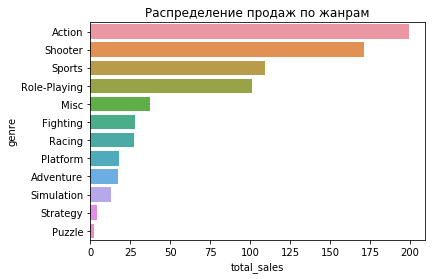

In [ ]:
sns.barplot(y=genres.index, x="total_sales", data=genres)
plt.title("Распределение продаж по жанрам")

(0, 2)

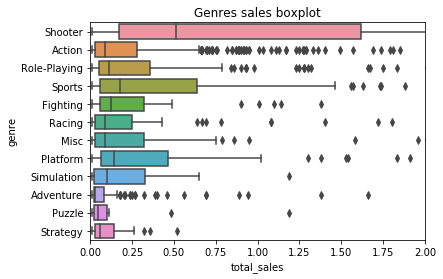

In [ ]:
sns.boxplot(y="genre", x='total_sales', data=actual_data).set_title('Genres sales boxplot')
plt.xlim(0, 2)

Из таблицы и графика видим, что самый прибыльный жанр за актуальный период - action, затем идет shooter, sports и role-playing. Из боксплота видим, что средняя цена за игру shooter выше, чем за все остальные.

Наименее прибыльные жанры - puzzle, strategy и simulation.

## Портрет пользователя каждого региона

В данном шаге необходимо определить для пользователя каждого региона (NA, EU, JP):
- самые популярные платформы (топ-5);
- самые популярные жанры (топ-5);
- влияние рейтинга ESRB на продажи в отдельном регионе.

In [ ]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,RP,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,RP,7.98


Построим сводные таблицы и графики для каждого региона и сделаем выводы.

In [ ]:
na_pl = actual_data.pivot_table(index='platform',values='na_sales',aggfunc='sum').sort_values(by = 'na_sales', ascending = False)
na_pl

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05
WiiU,19.36
PC,7.23
PSV,2.52
Wii,2.08


Text(0.5, 1.0, 'Распределение продаж по платформам в Северной Америке')

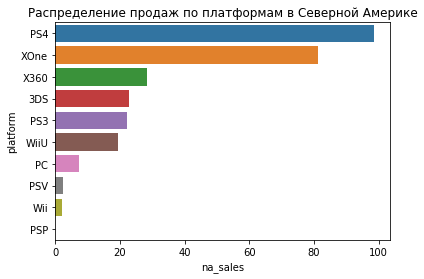

In [ ]:
sns.barplot(y=na_pl.index, x="na_sales", data=na_pl)
plt.title("Распределение продаж по платформам в Северной Америке")

In [ ]:
na_g = actual_data.pivot_table(index='genre',values='na_sales',aggfunc='sum').sort_values(by = 'na_sales', ascending = False)
na_g

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05
Fighting,12.43
Racing,8.74
Platform,6.79
Adventure,5.64


Text(0.5, 1.0, 'Распределение продаж по жанрам в Северной Америке')

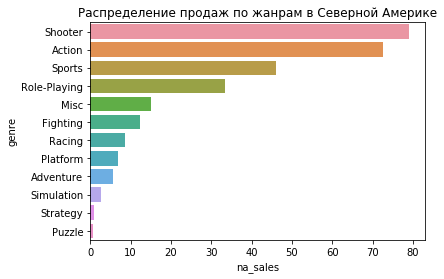

In [ ]:
sns.barplot(y=na_g.index, x="na_sales", data=na_g)
plt.title("Распределение продаж по жанрам в Северной Америке")

In [ ]:
na_rating = actual_data.pivot_table(index='rating',values='na_sales',aggfunc='sum').sort_values(by = 'na_sales', ascending = False)
na_rating

,na_sales
rating,
M,96.42
RP,64.72
E,50.74
T,38.95
E10+,33.23


Text(0.5, 1.0, 'Распределение продаж по рейтингу ESRB в Северной Америке')

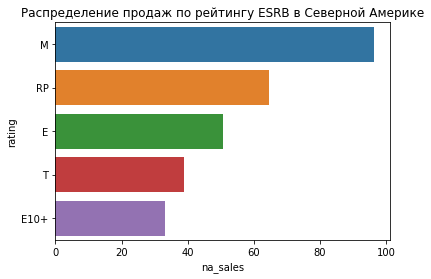

In [ ]:
sns.barplot(y=na_rating.index, x="na_sales", data=na_rating)
plt.title("Распределение продаж по рейтингу ESRB в Северной Америке")

In [ ]:
eu_pl = actual_data.pivot_table(index='platform',values='eu_sales',aggfunc='sum').sort_values(by = 'eu_sales', ascending = False)
eu_pl

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12
X360,15.49
WiiU,13.15
PSV,3.53
Wii,2.59


Text(0.5, 1.0, 'Распределение продаж по платформам в Европе')

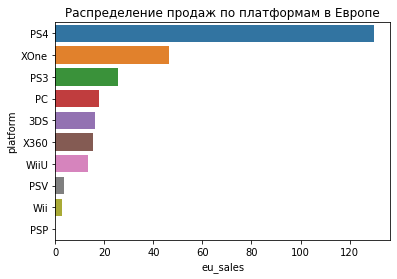

In [ ]:
sns.barplot(y=eu_pl.index, x="eu_sales", data=eu_pl)
plt.title("Распределение продаж по платформам в Европе")

In [ ]:
eu_g = actual_data.pivot_table(index='genre',values='eu_sales',aggfunc='sum').sort_values(by = 'eu_sales', ascending = False)
eu_g

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13
Misc,12.86
Simulation,7.30
Platform,6.80
Fighting,6.69


Text(0.5, 1.0, 'Распределение продаж по жанрам в Европе')

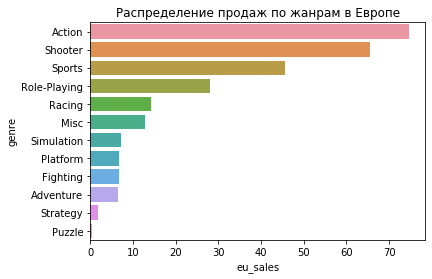

In [ ]:
sns.barplot(y=eu_g.index, x="eu_sales", data=eu_g)
plt.title("Распределение продаж по жанрам в Европе")

In [ ]:
eu_rating = actual_data.pivot_table(index='rating',values='eu_sales',aggfunc='sum').sort_values(by = 'eu_sales', ascending = False)
eu_rating

,eu_sales
rating,
M,93.44
RP,58.95
E,58.06
T,34.07
E10+,26.16


Text(0.5, 1.0, 'Распределение продаж по рейтингу ESRB в Европе')

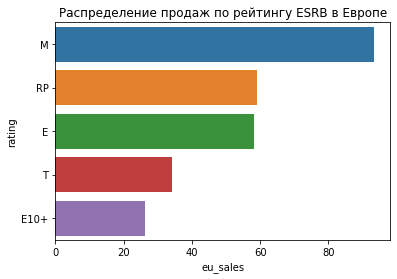

In [ ]:
sns.barplot(y=eu_rating.index, x="eu_sales", data=eu_rating)
plt.title("Распределение продаж по рейтингу ESRB в Европе")

In [ ]:
jp_pl = actual_data.pivot_table(index='platform',values='jp_sales',aggfunc='sum').sort_values(by = 'jp_sales', ascending = False)
jp_pl

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31
PSP,0.36
XOne,0.32
X360,0.08
PC,0.00


Text(0.5, 1.0, 'Распределение продаж по платформам в Японии')

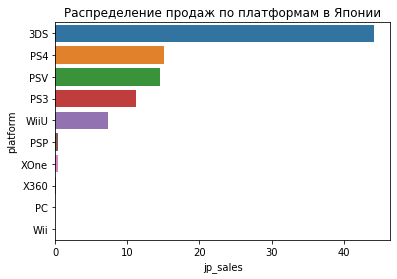

In [ ]:
sns.barplot(y=jp_pl.index, x="jp_sales", data=jp_pl)
plt.title("Распределение продаж по платформам в Японии")

In [ ]:
jp_g = actual_data.pivot_table(index='genre',values='jp_sales',aggfunc='sum').sort_values(by = 'jp_sales', ascending = False)
jp_g

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87
Adventure,3.60
Sports,3.26
Platform,2.69
Simulation,2.31


Text(0.5, 1.0, 'Распределение продаж по жанрам в Японии')

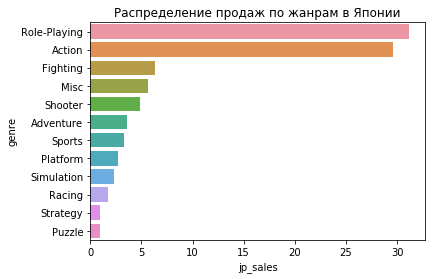

In [ ]:
sns.barplot(y=jp_g.index, x="jp_sales", data=jp_g)
plt.title("Распределение продаж по жанрам в Японии")

In [ ]:
jp_rating = actual_data.pivot_table(index='rating',values='jp_sales',aggfunc='sum').sort_values(by = 'jp_sales', ascending = False)
jp_rating

,jp_sales
rating,
RP,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


Text(0.5, 1.0, 'Распределение продаж по рейтингу ESRB в Японии')

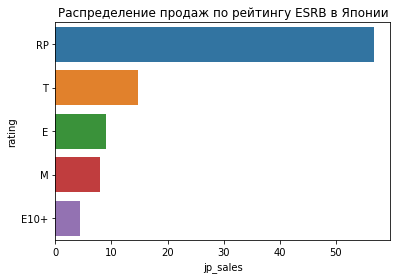

In [ ]:
sns.barplot(y=jp_rating.index, x="jp_sales", data=jp_rating)
plt.title("Распределение продаж по рейтингу ESRB в Японии")

Из полученных таблиц и графиков сделаем вывод по кажому региону и сравним их.

**Северная Америка**:
- *Топ-5 платформ*: PS4, XOne, X360, 3DS, PS3
- *Топ-5 жанров*: Shooter, Action, Sports, Role-Playing, Misc
- *Рейтинг*: M, RP, E, T, E10+

**Европа**:
- *Топ-5 платформ*: PS4, XOne, PS3, PC, 3DS	
- *Топ-5 жанров*: Action, Shooter, Sports, Role-Playing, Racing	
- *Рейтинг*: M, RP, E, T, E10+

**Япония**:
- *Топ-5 платформ*: 3DS, PS4, PSV, PS3, WiiU	
- *Топ-5 жанров*: Role-Playing, Action, Fighting, Misc, Shooter
- *Рейтинг*: RP, T, E, M, E10+	

Можем видеть, что в Северной Америке лидирует PS4, затем идут XBox, Nintendo и PS3. В то время как в Японии лидирует японский Nintendo 3DS и приставки PlayStation от японской компании Sony.

В Европе лидируют лидеры схожи на Северную Америку, но также есть PC и нет Xbox 360.

Топ-5 жанров в Северной Америке и Европе схожи: *Action, Shooter, Sports, Role-Playing* и отличаются только последней строчкой, *Misc* и *Racing* соответственно. В Японии список лидирует жанр *Role-Playing*, также в отличии от других есть жанр *Fighting*.

Рассматривая возрастной рейтинг, в Северной Америке и Европе большую часть продаж составляют игры рейтинга M (Mature 17+) и E (Everyone), не включая пропущенные значения, включенные в рейтинг RP (Rating Pending), в то время как в Японии большую часть составляет рейтинг RP, то есть по данным из Японии в столбце с рейтингом были преимущественно пропуски, затем следует рейтинг T (Teen) и E (Everyone). Пятерку во всех трех регионах закрывает рейтинг E10+ (Everyone 10+).

## Проверка гипотез

В данном шаге нужно проверить гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Начнём с формулировки **нулевой гипотезы H₀** (она всегда должна содержать в себе равенство): *средние пользовательские рейтинги платформ Xbox One равны пользовательским рейтингам платформы PC*.

**Альтернативная гипотеза H₁**: *средние пользовательские рейтинги платформ Xbox One и PC различаются*.

In [ ]:
xone = actual_data.query('platform == "XOne"')['user_score']
pc = actual_data.query('platform == "PC"')['user_score']

Чтобы определить критический уровень статистической значимости alpha, проверим количество единиц в выборках.

In [ ]:
len(xone)

228

In [ ]:
len(pc)

151

В наших выборках меньше 1000 единиц, поэтому возьмем уровень значимости alpha равным 0.01.

In [ ]:
alpha = 0.01

results = st.ttest_ind (xone, pc, nan_policy='omit', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.11601398086668985
Не получилось отвергнуть нулевую гипотезу


При проверке видим, что нулевая гипотеза не была опровергнута, то есть средние пользовательские рейтинги платформ Xbox One и PC равны. Сделаем расчеты, чтобы наглядно увидеть средние значения.

In [ ]:
median_user_score = actual_data.query('platform == ["XOne","PC"]').pivot_table(index='platform', values=['user_score'], aggfunc='median')
median_user_score

,user_score
platform,
PC,6.8
XOne,6.8


Исходя из таблицы можно уверенно сказать, что средние пользовательские рейтинги двух платформ равны 6.8.

Перейдем к проверке второй гипотезы.

**Нулевая гипотеза H₀**: *средние пользовательские рейтинги жанров Action и Sports равны*.

**Альтернативная гипотеза H₁**: *средние пользовательские рейтинги жанров Action и Sports различны*.

Чтобы определить критический уровень статистической значимости alpha, проверим также количество единиц в выборках.

In [ ]:
action = actual_data.query('genre == "Action"')['user_score']
sports = actual_data.query('genre == "Sports"')['user_score']

In [ ]:
len(action)

619

In [ ]:
len(sports)

161

В наших выборках меньше 1000 единиц, поэтому чтобы уверенно отвергнуть нулевую гипотезу возьмем уровень значимости alpha равным 0.01.

In [ ]:
alpha = 0.01

results = st.ttest_ind (action, sports, nan_policy='omit', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1825550382644845e-14
Отвергаем нулевую гипотезу


При проверке видим, что нулевая гипотеза была опровергнута, то есть средние пользовательские рейтинги жанров Action и Sports различны. Сделаем расчеты, чтобы наглядно увидеть средние значения.

In [ ]:
median_user_score1 = actual_data.query('genre == ["Action","Sports"]').pivot_table(index='genre', values=['user_score'], aggfunc='median')
median_user_score1

,user_score
genre,
Action,7.1
Sports,5.5


Из таблицы видим, что пользовательские рейтинги двух жанров равны 7.1 и 5.5.

## Общий вывод

В данном проекте нужно было найти параметры, которые определяют успешность игры. Были проанализированы данные до 2016 года, чтобы спрогнозировать продажи на 2017 год и помочь спланировать рекламные кампании. 

Просуммируем полученные выводы:
- Самое большое число игр было выпущено в 2008 и 2009 году, 1427 и 1426 соответственно.
- Наибольшие продажи за все время были на шести платформах: PS2, X360, PS3, Wii, DS, PS.
- Средний жизненный цикл платформы составляет 5 лет, поэтому актуальный период был выбран 2011-2016.
- В актуальный период лидерами по продажам являются платформы PS3, X360, PS4 и 3DS.
- Есть зависимость общего количества продаж от оценок критиков. Проанализировав лидирующие платформы в актуальный период, коэффициент корреляции равен 0.34-0.40.
- Самый прибыльный жанр за актуальный период - action, затем идут shooter, role-playing и sports. Наименее прибыльные жанры - puzzle, strategy и adventure.
- Были составлены портреты пользователей каждого региона, пользователи в Северной Америке и Европе схожи по выбору платформ, жанров и возрастному рейтингу. В Японии используются только японские платформы и жанры отличаются от других регионов.
- Были проведены проверки гипотез и получены результаты: средние пользовательские рейтинги платформ Xbox One и PC различаются и средние пользовательские рейтинги жанров Action и Sports равны.